In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import patsy as pat
import seaborn as sbn
import nibabel as nib
from scipy import stats
from scipy import io as sio
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as sln
from sklearn import preprocessing as skp
from statsmodels.sandbox.stats.multicomp import multipletests as stm

In [4]:
# Paths
conn_p = '/project/6003287/PROJECT/simon_project/glm/abide_big/mist64/individual'
pheno_p = '/project/6003287/PROJECT/simon_project/pheno/abide_large_sample.csv'
figure_p = '/project/6003287/PROJECT/simon_project/figures/'
del_con_p = '/project/6003287/PROJECT/simon_project/glm/sample_low_motion/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'
conn_t = 'connectome_s{}_mist64.mat'
labels_p = '/home/surchs/sim_big/ATLAS/MIST/Parcel_Information/MIST_64.csv'
temp_p = '/project/6003287/ATLAS/MIST/Parcellations/MIST_64.nii.gz'

In [5]:
# Load the MIST64 template
temp_i = nib.load(temp_p)
mist64 = temp_i.get_data()

In [6]:
def octvec2mat(vec, mask):
    """
    Takes a vector in Fortran style (Octave/Matlab)
    and maps it back into a mask correctly in 
    python
    """
    vec_mat = mask.flatten(order='F').astype(bool)
    tmp = np.zeros_like(vec_mat, dtype=float)
    tmp[vec_mat] = vec
    vol = np.reshape(tmp, mask.shape, order='F')
    return vol

In [7]:
def vec2mat(vec, mask):
    tmp_mat = octvec2mat(vec, mask)
    tmp_mat += tmp_mat.T
    tmp_mat[np.eye(mask.shape[0]).astype(bool)] = tmp_mat[np.eye(mask.shape[0]).astype(bool)]/2
    return tmp_mat

In [8]:
# Get the pheno file
pheno = pd.read_csv(pheno_p)
labels = pd.read_csv(labels_p, delimiter=';')

In [9]:
# Get the connectomes
conn = np.array([sio.loadmat(os.path.join(conn_p, conn_t.format(row['SUB_ID'])))['motion']['connectome'][0][0]
        for rid, row in pheno.iterrows()]).squeeze()

In [10]:
# Prepare regression, with control as reference
model = pat.dmatrix('SITE_ID+FD_scrubbed', data=pheno, return_type='dataframe')

In [11]:
# Run the glm
mod = sln.LinearRegression(fit_intercept=False, normalize=True)
res = mod.fit(model, conn)
# Get the residuals
resid = conn - res.predict(model)

In [12]:
# Get the reference
ref_pattern = np.array(sio.loadmat(del_con_p)['eff']).squeeze()
# Map back to matrix
ref_mat = octvec2mat(ref_pattern, np.tril(np.ones((64,64))).astype(bool))
ref_mat += ref_mat.T
dref = ref_mat[np.identity(64, dtype=bool)]
ref_mat[np.identity(64, dtype=bool)] = dref/2

In [13]:
# Get the percent discovery
glm_del_con = sio.loadmat(del_con_p)
beta_del_con = glm_del_con['eff'].squeeze()
fdr_del_con = glm_del_con['fdr']
# Generate the matrices
mat_del_con = vec2mat(beta_del_con, np.tril(np.ones((64, 64))).astype(bool))
# Threshold the matrices
thr_del_con = np.zeros_like(mat_del_con)
thr_del_con[fdr_del_con<0.05] = mat_del_con[fdr_del_con<0.05]

In [14]:
resid_mat = np.array([octvec2mat(resid[i, :], np.tril(np.ones((64,64))).astype(bool)) for i in range(resid.shape[0])])
full_mat = np.array([resid_mat[i, ...] + resid_mat[i, ...].T for i in range(resid_mat.shape[0])])
# Remove duplicates on diagnonal
diag = full_mat[..., np.identity(64, dtype=bool)]
full_mat[..., np.identity(64, dtype=bool)] = diag/2

In [15]:
# Make weights for each node
weights = np.zeros((full_mat.shape[0], ref_mat.shape[0]))
for i in range(64):
    for j in range(full_mat.shape[0]):
        weights[j, i] = np.corrcoef(ref_mat[i, :], full_mat[j, i, :])[0,1]

## Go for the diagnosis

In [16]:
con_idx = pheno['DX_GROUP']=='Control'
n_con = np.sum(con_idx)
n_asd = np.sum(~con_idx)
pl = list()
pid = list()
eff_l = list()
eff_ls = list()
gt = list()
for i in range(64):
    u_min, p = sp.stats.mannwhitneyu(weights[~con_idx, i], weights[con_idx, i], alternative=None)
    u_right, ppp = sp.stats.mannwhitneyu(weights[~con_idx, i], weights[con_idx, i], alternative='two-sided')
    eff = 1 - (2*u_min) / (n_asd*n_con)
    del_gt_con = u_right > u_min
    pl.append(p)
    if del_gt_con:
        eff_ls.append(eff)
    else:
        eff_ls.append(-eff)
    if p < 0.05:
        print(i+1, p, u_min, eff, del_gt_con)
        pid.append(i)
        gt.append(del_gt_con)
        if del_gt_con:
            eff_l.append(eff)
        else:
            eff_l.append(-eff)

1 2.1545562856148765e-07 43405.0 0.22606470708853765 True
2 0.018023997587551643 50825.0 0.09376197990496316 True
4 6.471033759674499e-05 46483.0 0.1711822550304457 True
5 0.004046177800117277 49441.0 0.1184394697192579 False
11 0.026845036736925117 51244.0 0.0862909768470227 True
13 0.004826921747853222 49592.0 0.11574705572940347 False
14 4.8709664327364204e-06 44990.0 0.19780327547317833 True
17 2.936268620931839e-07 43554.0 0.22340795421113158 True
18 0.037001676780417485 51602.0 0.07990763771875864 True
21 0.03636138044269217 51582.0 0.08026424884324268 False
31 0.0005000401770827329 47830.0 0.14716449579644642 True
34 8.454573438274314e-07 44076.0 0.2141004038620985 True
45 0.03069200775731849 51391.0 0.08366988508206519 True
46 0.038045297655877275 51634.0 0.07933705991958417 True
49 0.011029269210912938 50341.0 0.10239196911747661 True
51 4.5621619937982865e-07 43769.0 0.21957438462292833 True
52 0.002186399953379577 48935.0 0.12746173116870385 True
53 0.02587083497733921 51204

In [17]:
dx_ind = np.where(stm(pl, alpha=0.05, method='fdr_bh')[0])[0]

In [18]:
dx_ind

array([ 0,  3,  4, 12, 13, 16, 30, 33, 50, 51, 57])

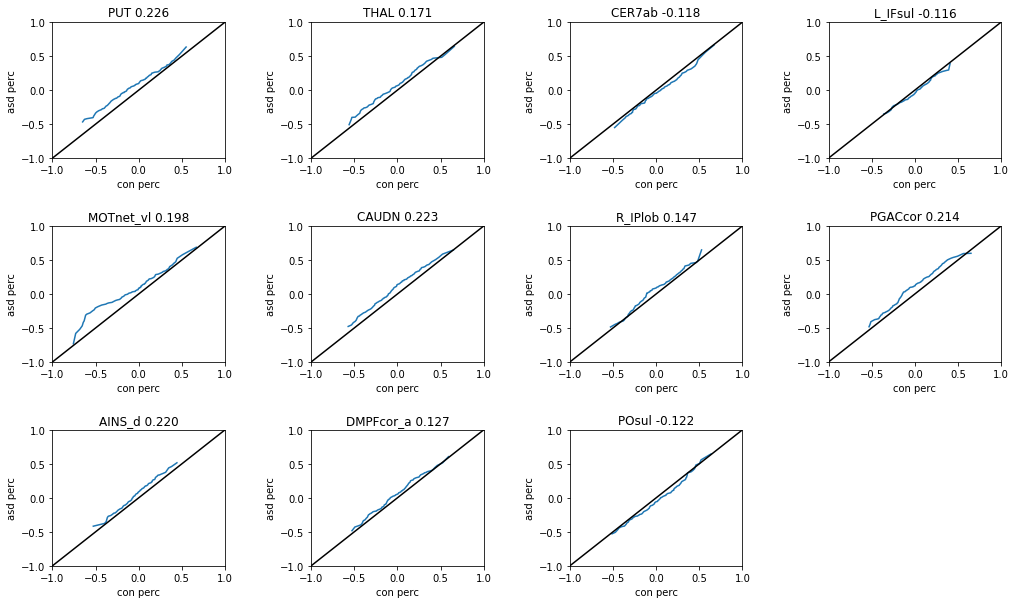

In [19]:
# We have 20 significant tests
f = plt.figure(figsize=(17,10))
gsp = gridspec.GridSpec(3, 4, hspace=0.5, wspace=0.5)
for fig_id, ind in enumerate(dx_ind):
    r_name = labels[labels['roi']==ind+1]['label'].values[0]
    ww = weights[:, ind]
    w_con = ww[con_idx]
    w_asd = ww[~con_idx]
    pp_con = [np.percentile(w_con, i) for i in np.linspace(1,100,100)]
    pp_asd = [np.percentile(w_asd, i) for i in np.linspace(1,100,100)]
    ax = f.add_subplot(gsp[fig_id])
    ax.plot(pp_con, pp_asd)
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.plot(ax.get_xlim(), ax.get_ylim(), 'k')
    ax.set_ylabel('asd perc')
    ax.set_xlabel('con perc')
    ax.set_title('{} {:.3f}'.format(r_name, eff_ls[ind]))
f.savefig(os.path.join(figure_p, '16p_connectivity_fdr_bigsample_qq.png'), dpi=300, bbox_inches='tight', pad_inches=0)

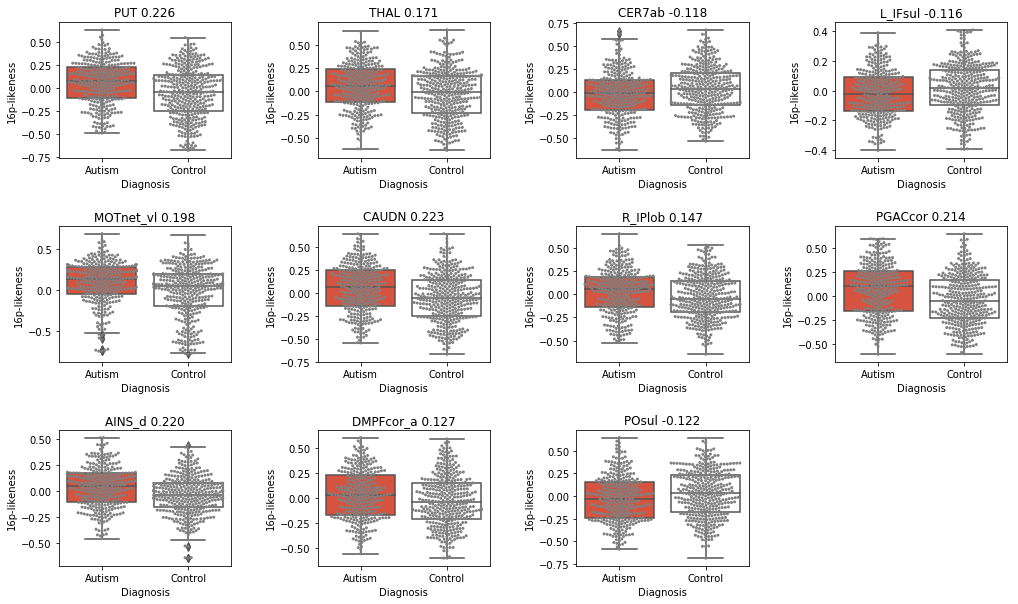

In [34]:
# We have 20 significant tests
f = plt.figure(figsize=(17,10), constrained_layout=True)
gsp = gridspec.GridSpec(3, 4, hspace=0.5, wspace=0.5)
for fig_id, ind in enumerate(dx_ind):
    r_name = labels[labels['roi']==ind+1]['label'].values[0]
    ax = f.add_subplot(gsp[fig_id])
    p = pheno.copy()
    p['weights'] = weights[:, ind]
    sbn.boxplot(y='weights', x='DX_GROUP', data=p, ax=ax, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y='weights', x='DX_GROUP', data=p, ax=ax, color='grey', size=3)
    ax.set_ylabel('16p-likeness')
    ax.set_xlabel('Diagnosis')
    ax.set_title('{} {:.3f}'.format(r_name, eff_ls[ind]))
f.savefig(os.path.join(figure_p, '16p_connectivity_fdr_bigsample.png'), dpi=300, transparent=True)

In [21]:
# Now we also want the effect sizes in the brain
abide_diagnosis_vol = np.zeros(mist64.shape)
for eff_id in dx_ind:
    abide_diagnosis_vol[mist64==eff_id+1] = eff_ls[eff_id]
abide_diagnosis_img = nib.Nifti1Image(abide_diagnosis_vol, header=temp_i.header, affine=temp_i.affine)
nib.save(abide_diagnosis_img, os.path.join(figure_p, 'abide_delcon_diagnosis_effect_bigsample.nii.gz'))

In [22]:
# Define the x, y, z coordinates for best comparison to VBM maps
vbm_cuts = (-38, -20, 7)

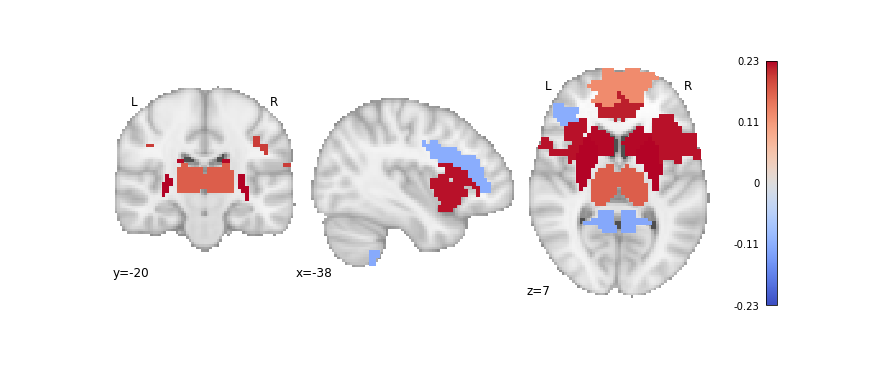

In [28]:
# And also plot it
f = plt.figure(figsize=(12,5), constrained_layout=True)
ax = f.add_subplot(111)
nlp.plot_stat_map(abide_diagnosis_img, cut_coords=vbm_cuts, axes=ax, cmap=plt.cm.coolwarm, draw_cross=False, colorbar=True)
f.savefig(os.path.join(figure_p, 'abide_delcon_diagnosis_bigsample.png'), dpi=300, transparent=True)

## Percent Discovery

In [25]:
pd_del_con_v = np.sum(thr_del_con!=0, 0)/64

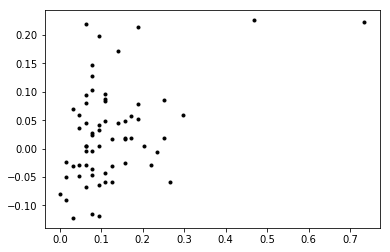

In [27]:
plt.plot(pd_del_con_v, eff_ls, '.k')

In [29]:
eff_a = np.array(eff_ls)

In [33]:
# Put this information in a dataframe together with the percent discovery
comparison_table = pd.DataFrame(data=np.concatenate((eff_a[:, None], pd_del_con_v[:, None]), 1), 
                                columns=['effect size', 'percent discovery'])
# Add a column on whether the corresponding region is in the top 3
top_ind = [True if roi in dx_ind else False for roi in range(64)]
comparison_table['is_top'] = top_ind

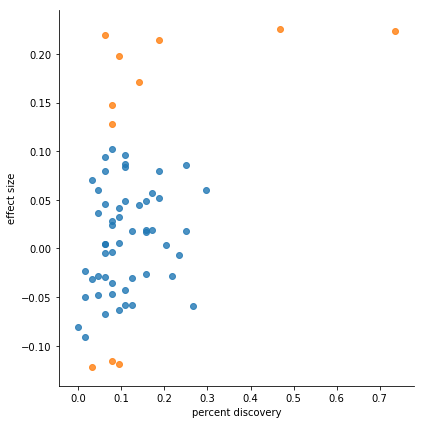

In [34]:
# Plot the relationship
# Show the greater than effect map
sbn_plot = sbn.lmplot(x='percent discovery', y='effect size', hue='is_top', 
                data=comparison_table, fit_reg=False, size=6, aspect=1, legend=False)
sbn_plot.savefig(os.path.join(figure_p, 'vbm_eff_vs_fc_roi_eff.png'), 
                 dpi=300, bbox_inches='tight', pad_inches=0)

## ADOS

In [21]:
# Get only subjects who have ADOS values
ados_ind = ~pheno.ADOS_GOTHAM_SEVERITY.isnull()
p_ados = pheno.loc[ados_ind]
pv_ados = list()
rv_ados = list()
id_ados = list()
for i in range(64):
    r, p = sp.stats.pearsonr(weights[ados_ind, i], p_ados['ADOS_GOTHAM_SEVERITY'].values)
    pv_ados.append(p)
    rv_ados.append(r)
    if p < 0.05:
        print(i, r, p)
        id_ados.append(i)

27 -0.1696198689913149 0.027475590387701213
36 -0.173398954125848 0.024160768520396905
40 -0.2405571359119343 0.0016303182047499411
57 -0.1725536339931264 0.02487079033704332
62 0.1545639190742035 0.044803722078890176


In [22]:
ados_ind = np.where(stm(pv_ados, alpha=0.05, method='fdr_bh')[0])[0]

In [23]:
ados_ind

array([], dtype=int64)

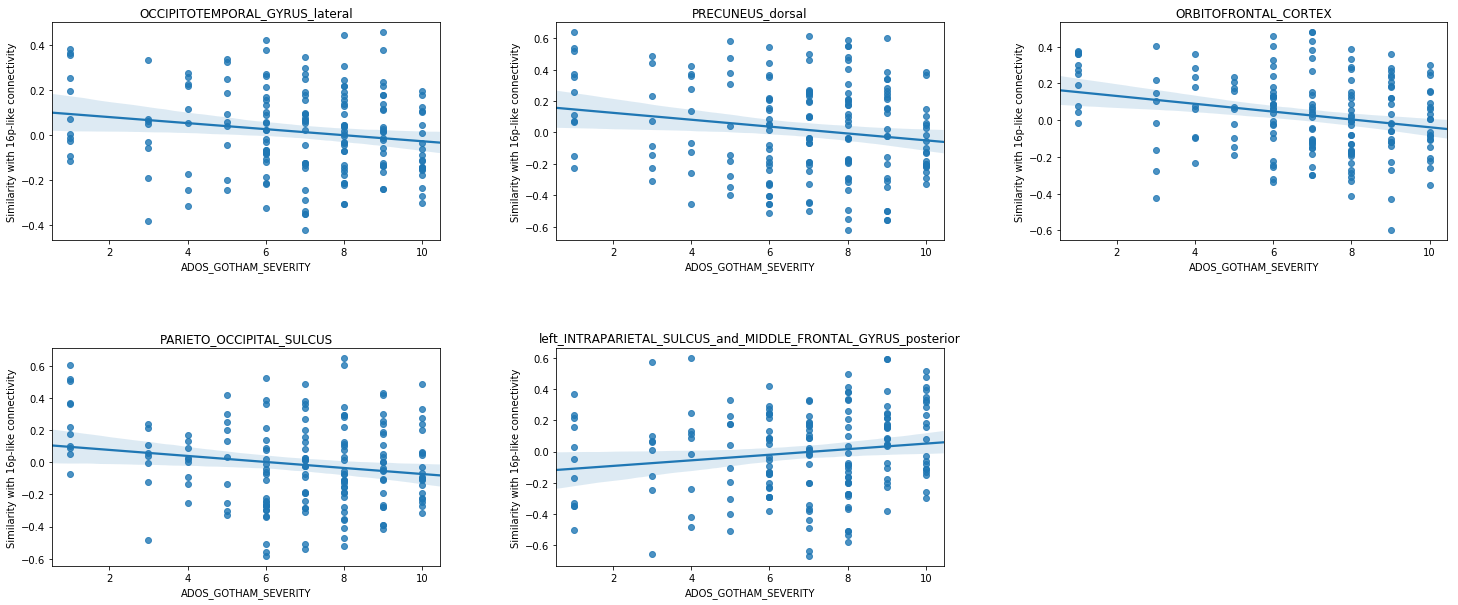

In [24]:
# Plot the last 10 as B
f = plt.figure(figsize=(25,10))
gsp = gridspec.GridSpec(2, 3, hspace=0.5, wspace=0.3)
for fig_id, ind in enumerate(id_ados):
    r_name = labels[labels['roi']==ind+1]['name'].values[0]
    ax = f.add_subplot(gsp[fig_id])
    p = pheno.copy()
    p['weights'] = weights[:, ind]
    sbn.regplot(y='weights', x='ADOS_GOTHAM_SEVERITY', data=p, ax=ax)
    ax.set_ylabel('Similarity with 16p-like connectivity')
    ax.set_xlabel('ADOS_GOTHAM_SEVERITY')
    ax.set_title('{}'.format(r_name))
#f.savefig(os.path.join(figure_p, '16p_connectype_in_abide_ados_fdr_corrected_low_motion_b.png'), dpi=300, bbox_inches='tight', pad_inches=0)

## Other things

In [ ]:
pheno.SRS_RAW_TOTAL

In [46]:
# Get only subjects who have ADOS values
some = 'SRS_RAW_TOTAL'
some_ind = ~pheno[some].isnull()
p_some = pheno.loc[some_ind]
pv_some = list()
rv_some = list()
id_some = list()
for i in range(64):
    r, p = sp.stats.pearsonr(weights[some_ind, i], p_some[some].values)
    pv_some.append(p)
    rv_some.append(r)
    if p < 0.05:
        print(i, r, p)
        id_some.append(i)

0 0.12720434748214382 0.0453673441063475
13 0.13667510153352397 0.03142930461128534
16 0.23582869295933406 0.00017819817617945182
18 -0.15188423108988738 0.01667960943822562
33 0.14195698685814703 0.025379277421994063
51 0.16389081282652257 0.009726012006756263
57 -0.14380600107643224 0.023512460777278754


In [47]:
some_ind = np.where(stm(pv_some, alpha=0.05, method='fdr_bh')[0])[0]

In [50]:
some_ind

array([16])

In [53]:
labels[labels['roi']==17]['name'].values[0]

'CAUDATE_NUCLEUS'

In [48]:
len(some_ind)

1

ValueError: Length of values does not match length of index

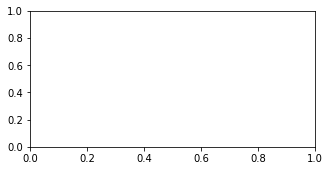

In [49]:
# Plot the last 10 as B
f = plt.figure(figsize=(25,10))
gsp = gridspec.GridSpec(3, 4, hspace=0.5, wspace=0.3)
for fig_id, ind in enumerate(id_some):
    r_name = labels[labels['roi']==ind+1]['name'].values[0]
    ax = f.add_subplot(gsp[fig_id])
    p = p_some.copy()
    p['weights'] = weights[:, ind]
    sbn.regplot(y='weights', x=some, data=p, ax=ax)
    ax.set_ylabel('Similarity with 16p-like connectivity')
    ax.set_xlabel(some)
    ax.set_title('{}'.format(r_name))
#f.savefig(os.path.join(figure_p, '16p_connectype_in_abide_ados_fdr_corrected_low_motion_b.png'), dpi=300, bbox_inches='tight', pad_inches=0)